# Time Series Forecasting with XGBoost



We will be using an hourly energy consumption dataset from Kaggle at https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption. The dataset captures energy consumption for different regions in a portion of the country. These values are at an hourly basis for over ten years. The data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.


In [2]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')    # This is a popular style choice for matplotlib

## Step 0. Data Preprocessing

In [3]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index) #The dataframe index is an object, we need to convert it to a datetime object.

In [4]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [5]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


We see from the head and tail functions that the data is in hourly format, from 2002 to 2018.

In [7]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


Lets plot this to visualize what we are working with.

<Axes: title={'center': 'PJME Power Consumption (in MW)'}, xlabel='Datetime'>

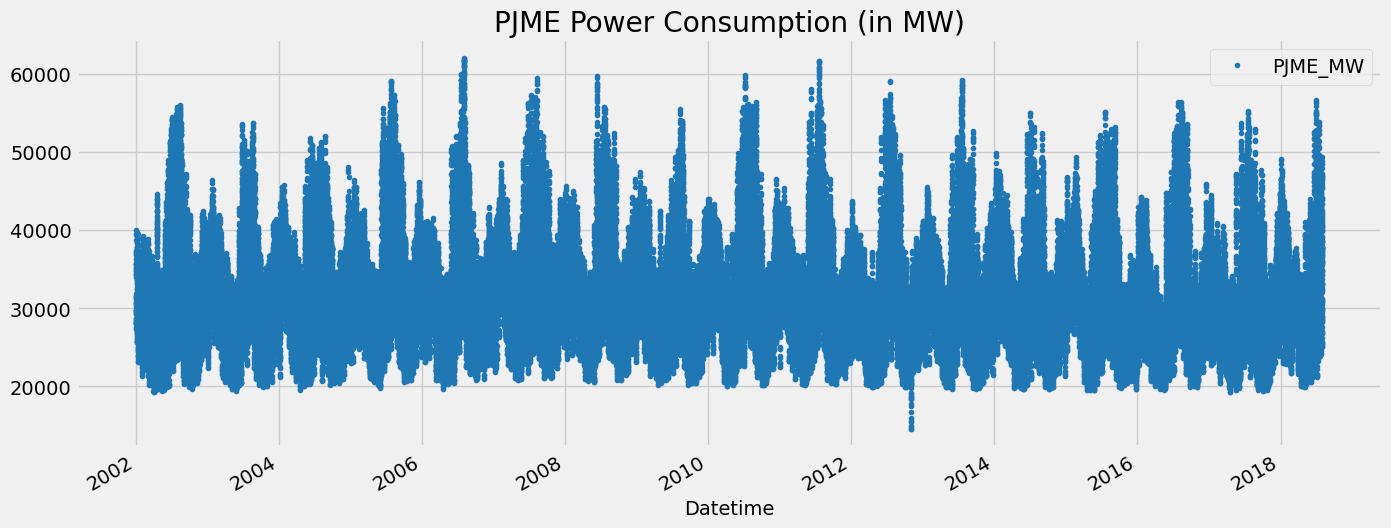

In [5]:
df.plot(style='.',
        figsize=(15, 6),
        color=color_pal[0], 
        title="PJME Power Consumption (in MW)")

Looking at the graph above, there appears to be an area around 2012/2013 where the data appears to be really low. There good be data quality issues. Perhaps there were blackouts during that time or issues with the sensors.  ML models will learn from these outliers so we need to investigate further. Let’s zoom in on that area to see what’s going on.

## Step 2.  Train/Test Split

In [8]:
df.shape

(145366, 1)

We are going to split the data on the date January, 2015. The reason for this is that we want to train our model on data before this date and test our model on data after this date. This is a common practice in time series modeling.            

In [9]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

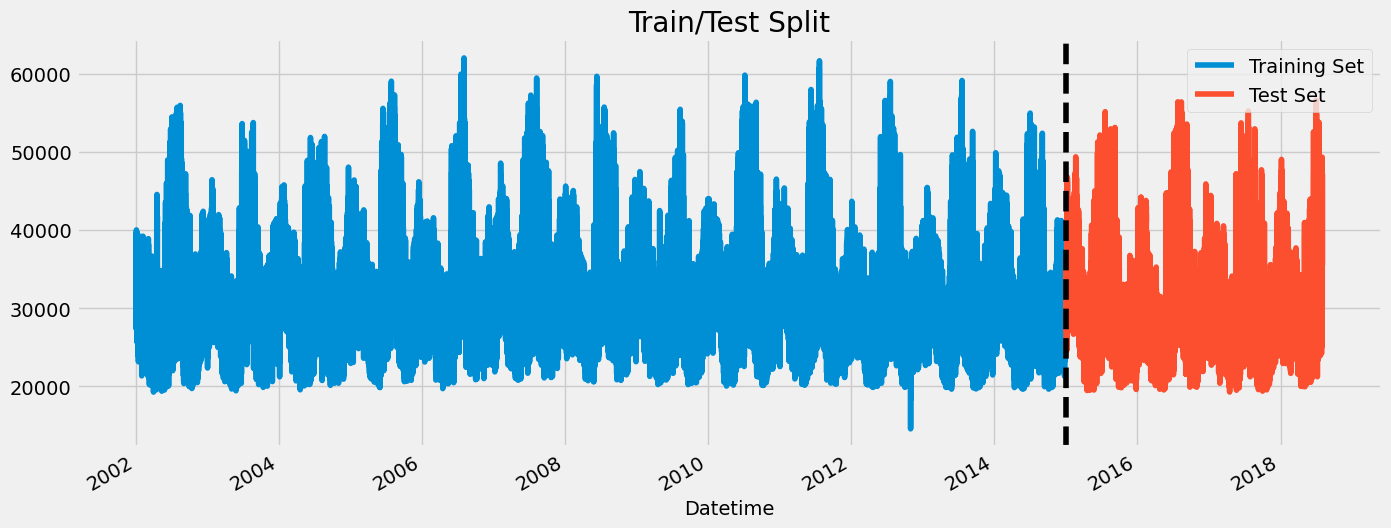

In [10]:
fig, ax = plt.subplots(figsize=(15, 6))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
ax.axvline(pd.to_datetime('01/01/2015'), color='k', linestyle='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_title('Train/Test Split')
plt.show()

Next, lets get an idea of what one single week looks like in the data. We can see that there is a clear trend and seasonality to the data. The trend is that the power consumption is increasing over time, and the seasonality is that there is a yearly pattern to the power consumption. 

In [2]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')]\
    .plot(figsize=(15, 6), title='A Week of Data')
plt.show()

NameError: name 'df' is not defined

We can notice a few things here;
* Within each day, there are 2 different peaks. This is fairly common in energy consumption.
* There also appears to be valleys during the nights
* A weekend/holiday effect seems to be taking place as well with lower overall consumption.

## Step 3. Feature Engineering


We can use pandas .hour attribute to get the hour of the day for each index. We can also use other attributes to pull additional data from the index.  To make this cleaner, will create a function called features for our engineering.
   
We will add these as new columns to our dataframe.


In [26]:

def create_features(df):
    """
    Creates time series features from datetime index
    """
    df = df.copy() # We don't want to modify the original dataframe
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek # Monday=0, Sunday=6
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

In [27]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1


## Visualizing the Feature / Target Relationship

Text(0.5, 1.0, 'Hourly Boxplot of Energy Consumption (in MWh)')

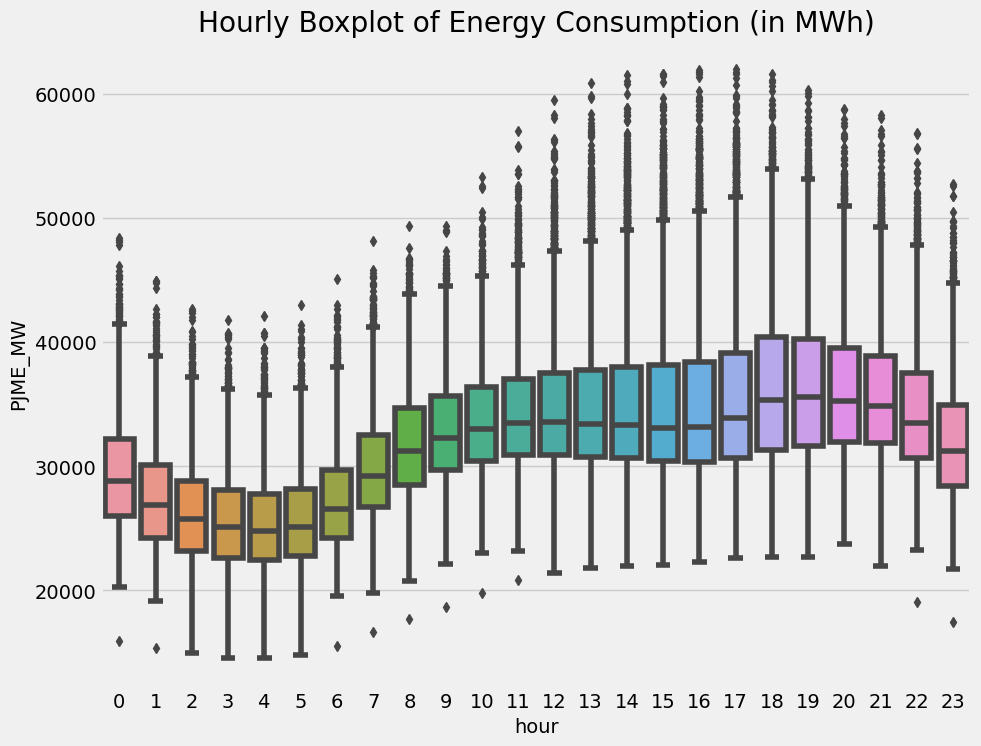

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(df, x='hour', y='PJME_MW')
ax.set_title('Hourly Boxplot of Energy Consumption (in MWh)')    # This is a style of plot

We see that early in the morning, there appears to be a dip in energy usage until 5.  It tends to get higher in the evening.

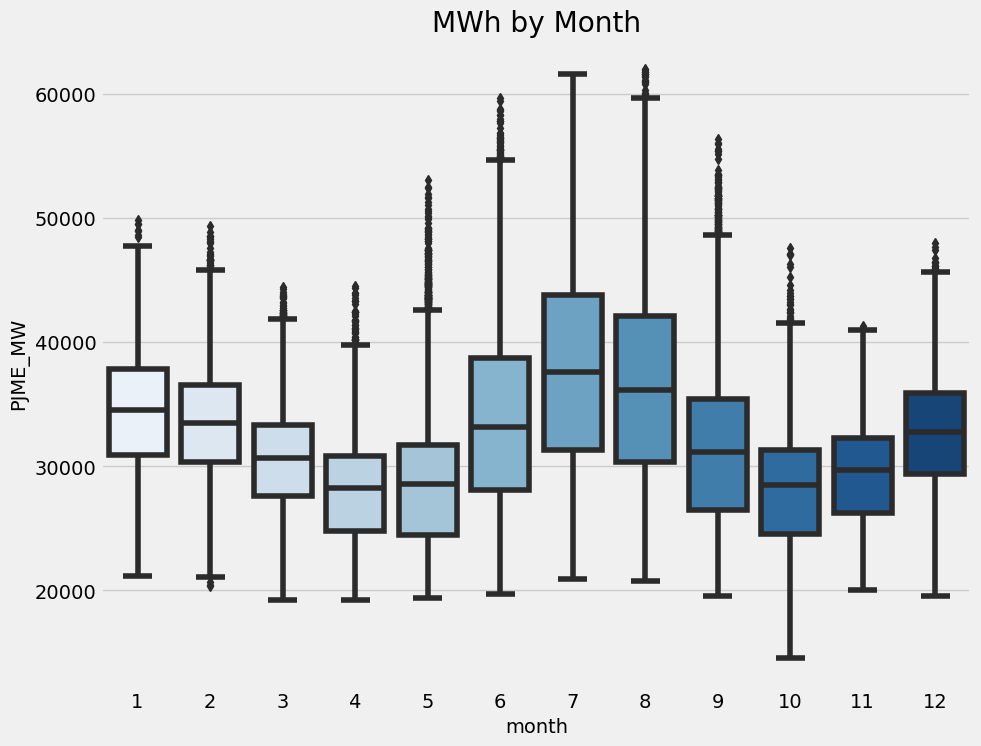

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MWh by Month') 
plt.show()

The MW usage by month tends to peak two times, in the winter season and again in the Summer

## Model Creation
  
  This model will be created on the training data and evaluated on the test data set.

In [16]:
# We need to run the training and testing data through the same features function
train = create_features(train)
test = create_features(test)

In [17]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [18]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [19]:
# we need to drop the target values from the training and testing datasets
# X_train = train.drop('PJME_MW', axis=1) # axis=1 means we are dropping a column instead of a row
# y_train = train['PJME_MW']

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]  



In [20]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                       learning_rate=0.01) 
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #early_stopping_rounds=50, # Activates early stopping. The model will train until the validation score stops improving.
        verbose=100) # If 'verbose' and an evaluation set is used, writes the evaluation metric measured on the validation set to stderr.

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935


[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[450]	validation_0-rmse:2771.93085	validation_1-rmse:3730.77469


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

The output shows that RMSE goes down through each iteration on the training set. However, the validation on the test set starts to go down but then begins to get worse after 10 iterations.
  
  This is indicative of overfitting with n_estimators=1000.  Another thing we can do is lower the learning rate.

With a learning rate of 0.01, and verbose set to show every 100 trees built.  This stopped at 450 trees because our test or validation set started to get worse after that many trees were built.

## Feature Importance
This will give us the importance values based on how much these features were used in each of the trees built by the XGBoost model.



In [25]:
# This is a list of the importance of each feature 
fi = pd.DataFrame(data=reg.feature_importances_,
             index= reg.feature_names_in_,
             columns=['importance'])


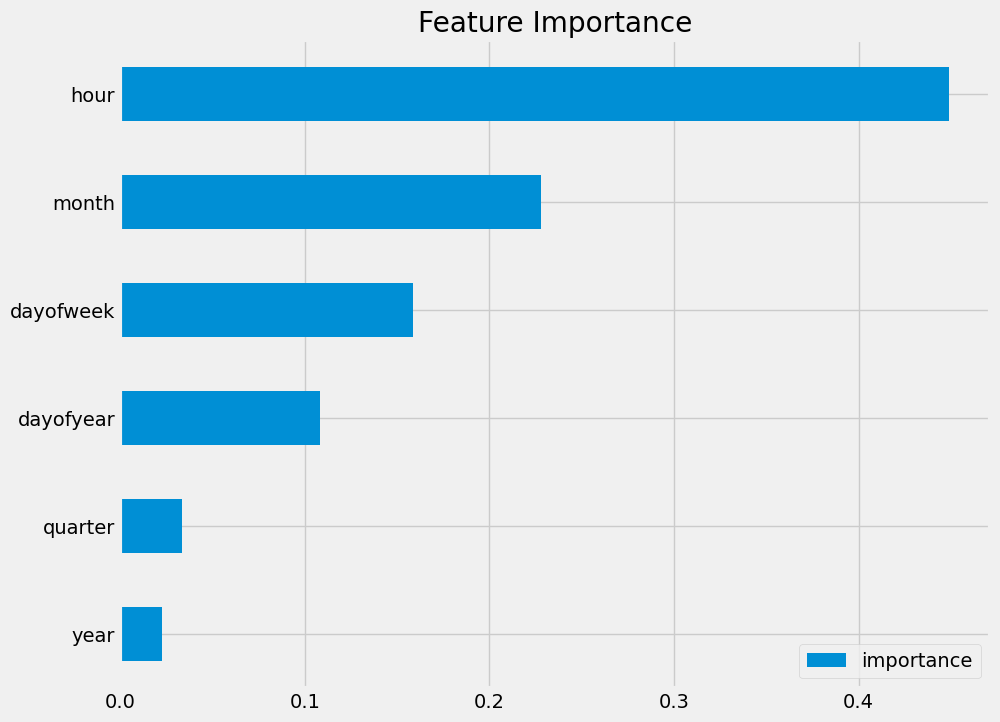

In [29]:
fi.sort_values(by='importance', ascending=True).plot(kind='barh', 
                                                      title='Feature Importance',
                                                      figsize=(10, 8)) 
plt.show()

Keep in mind that when you have highly correlated features, this feature importance functionality will not tell you exactly how important each feature is individually.

##  Forecast on Test


In [32]:
test['prediction'] = reg.predict(X_test)

Now I would like to see these predictions next to all the training data, so we will merge this.

In [38]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

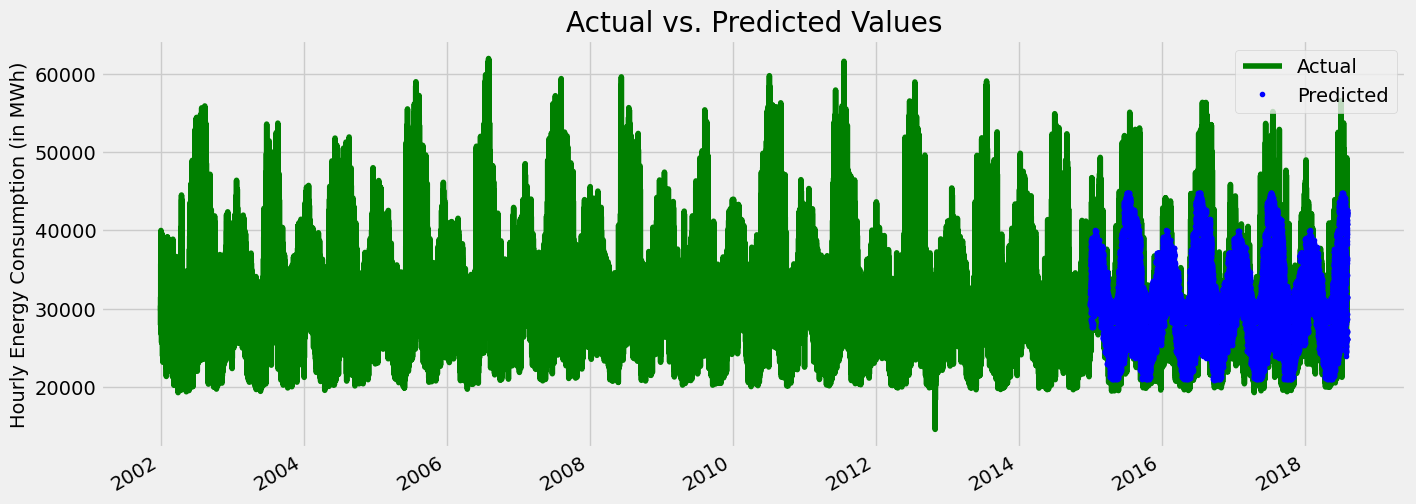

In [62]:
ax = df[['PJME_MW']].plot(figsize=(15, 6), color='green')
df['prediction'].plot(ax=ax, style='.', color = 'blue')
ax.set_title('Actual vs. Predicted Values')
ax.legend(['Actual', 'Predicted'])
ax.set_ylabel('Hourly Energy Consumption (in MWh)')
ax.set_xlabel('')
plt.show()


Similar to what was done previously, lets look at one week of data to see how the model performed.

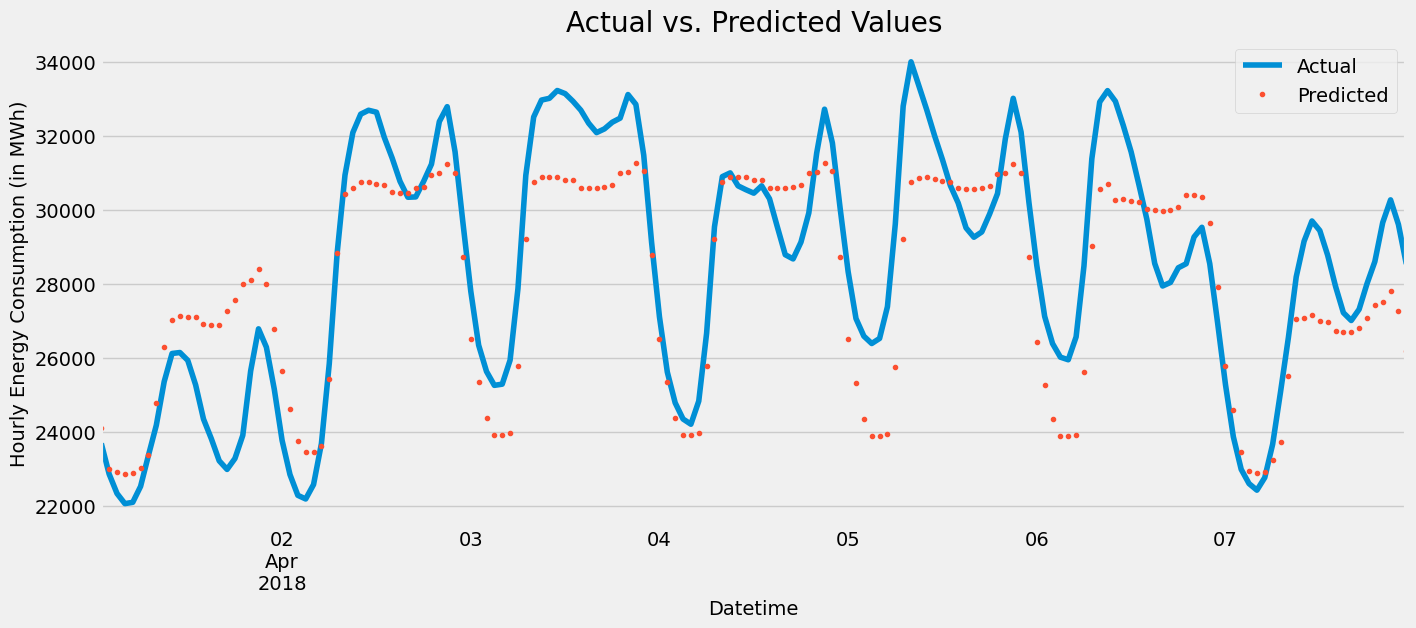

In [42]:

ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 6), title='A Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
ax.set_title('Actual vs. Predicted Values')
ax.legend(['Actual', 'Predicted'])
ax.set_ylabel('Hourly Energy Consumption (in MWh)')
plt.show()

We can see that the model isnt perfect. There is room for improvement. For example, this could include better parameter tuning.  Also, we could add in features for specific days of the year, like holidays.
    
The predictions do generally follow the trend you would expect to see with the peaks and valleys.

Lastly, we will run the evaluation metric on this

In [49]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction'])) # RMSE
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3715.93


### Calculate Error
* Look at the worst and best predicted days

In [50]:
test['error'] = np.abs(test[TARGET] -test['prediction'])

In [51]:
test['date'] = test.index.date

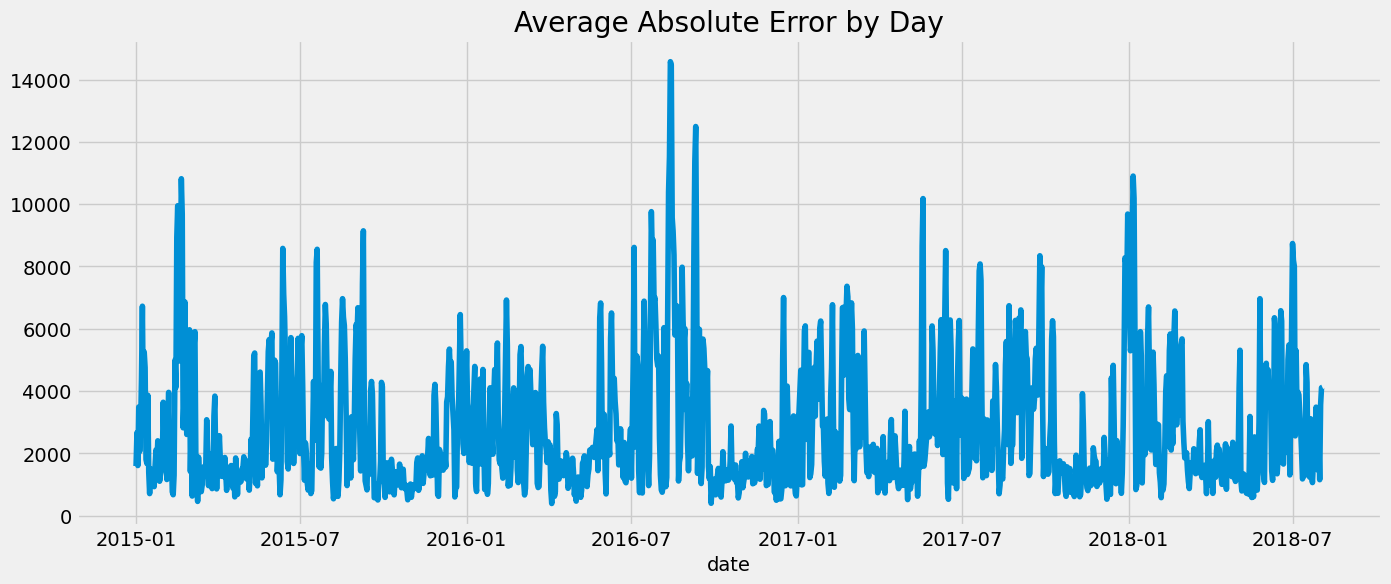

In [52]:
test.groupby('date')['error'].mean().plot(figsize=(15, 6),  
                                            title='Average Absolute Error by Day')
plt.show()

In [56]:
test.groupby('date')['error'].mean().sort_values().head(5)

date
2016-04-04    389.607829
2016-09-27    396.752116
2015-03-10    456.506510
2016-05-01    465.372640
2016-12-08    494.141764
Name: error, dtype: float64

Some of the best predictions were on days with the lowest average absolute error. These seem to be in 2016. 
  
  Next, Let's take a look at the worst days.

In [57]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
Name: error, dtype: float64

The worst predicted days all seem to be in the middle of August in 2016

### Next Steps:
- More robust cross-validation
- Add more features (i.e. Weather forecasts, holidays)

# The End